# Fitting of RecB dissociation rates with cipro, at different frame intervals

The goal of this notebook is to fit RecB's dissociation rate from DNA (from the spot lifetime histogram).

For each dataset, the bleaching rate is also fitted, and subtracted to retrieve the real dissociation rate (without the bleaching contribution).

### Data import

In the Spot_detection table we keep only one spot per track, so the track length histogram is unbiased (otherwise longer tracks have more spots).

In [1]:
from pyberries.data import DatasetPool
import seaborn.objects as so

data = (DatasetPool(path='/media/daniel/HDD Daniel/Daniel Thédié/BACMMAN/Timelapse',
                    dsList=['230425_1sec', '230713_1sec', '230718_1sec',
                            '230201_DT23', '230504_2sec', '230718_2sec',
                            '230425_5sec', '230504_5sec', '230713_5sec',
                            '230809_2', '230810_2', '230815_2',
                            '230822_1', '230824_2', '230829_2'],
                    groups=[1, 1, 1,
                            2, 2, 2,
                            5, 5, 5,
                            10, 10, 10,
                            20, 20, 20],
                    filters={'all':'Frame < 50'})
        .drop_duplicates(object_name='Spot_detection', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        )

Dataset 230425_1sec: loaded objects ['Bacteria_large', 'Spot_detection', 'RecB_raw']
Dataset 230713_1sec: loaded objects ['Bacteria_large', 'Spot_detection', 'RecB_raw']
Dataset 230718_1sec: loaded objects ['Bacteria_large', 'Spot_detection', 'RecB_raw']
Dataset 230201_DT23: loaded objects ['Bacteria_large', 'Spot_detection', 'RecB_raw']
Dataset 230504_2sec: loaded objects ['Bacteria_large', 'Spot_detection', 'RecB_raw']
Dataset 230718_2sec: loaded objects ['Bacteria_large', 'Spot_detection', 'RecB_raw']
Dataset 230425_5sec: loaded objects ['Bacteria_large', 'Spot_detection', 'RecB_raw']
Dataset 230504_5sec: loaded objects ['Bacteria_large', 'Spot_detection', 'RecB_raw']
Dataset 230713_5sec: loaded objects ['Bacteria_large', 'Spot_detection', 'RecB_raw']
Dataset 230809_2: loaded objects ['Bacteria_large', 'Spot_detection', 'RecB_raw']
Dataset 230810_2: loaded objects ['Bacteria_large', 'Spot_detection', 'RecB_raw']
Dataset 230815_2: loaded objects ['Bacteria_large', 'Spot_detection', '

## Bleaching rate fitting

The bleaching rate is fitted from the decay of the total fluorescence (background subtracted) contained in the cells, for each dataset.

In [2]:
from pyberries.data import Fit

bleaching_fit = Fit(data.Bacteria_large, x='Frame', y='SNR', groupby=['Group', 'Dataset'], model_type='monoexp_decay_offset', p0=[data.Bacteria_large.SNR.iloc[0], 1, 0])

### Plot the fits

Note that the fluorescence decays are well fit by a monoexponential function. This confirms that there is no significant blinking of the dye.

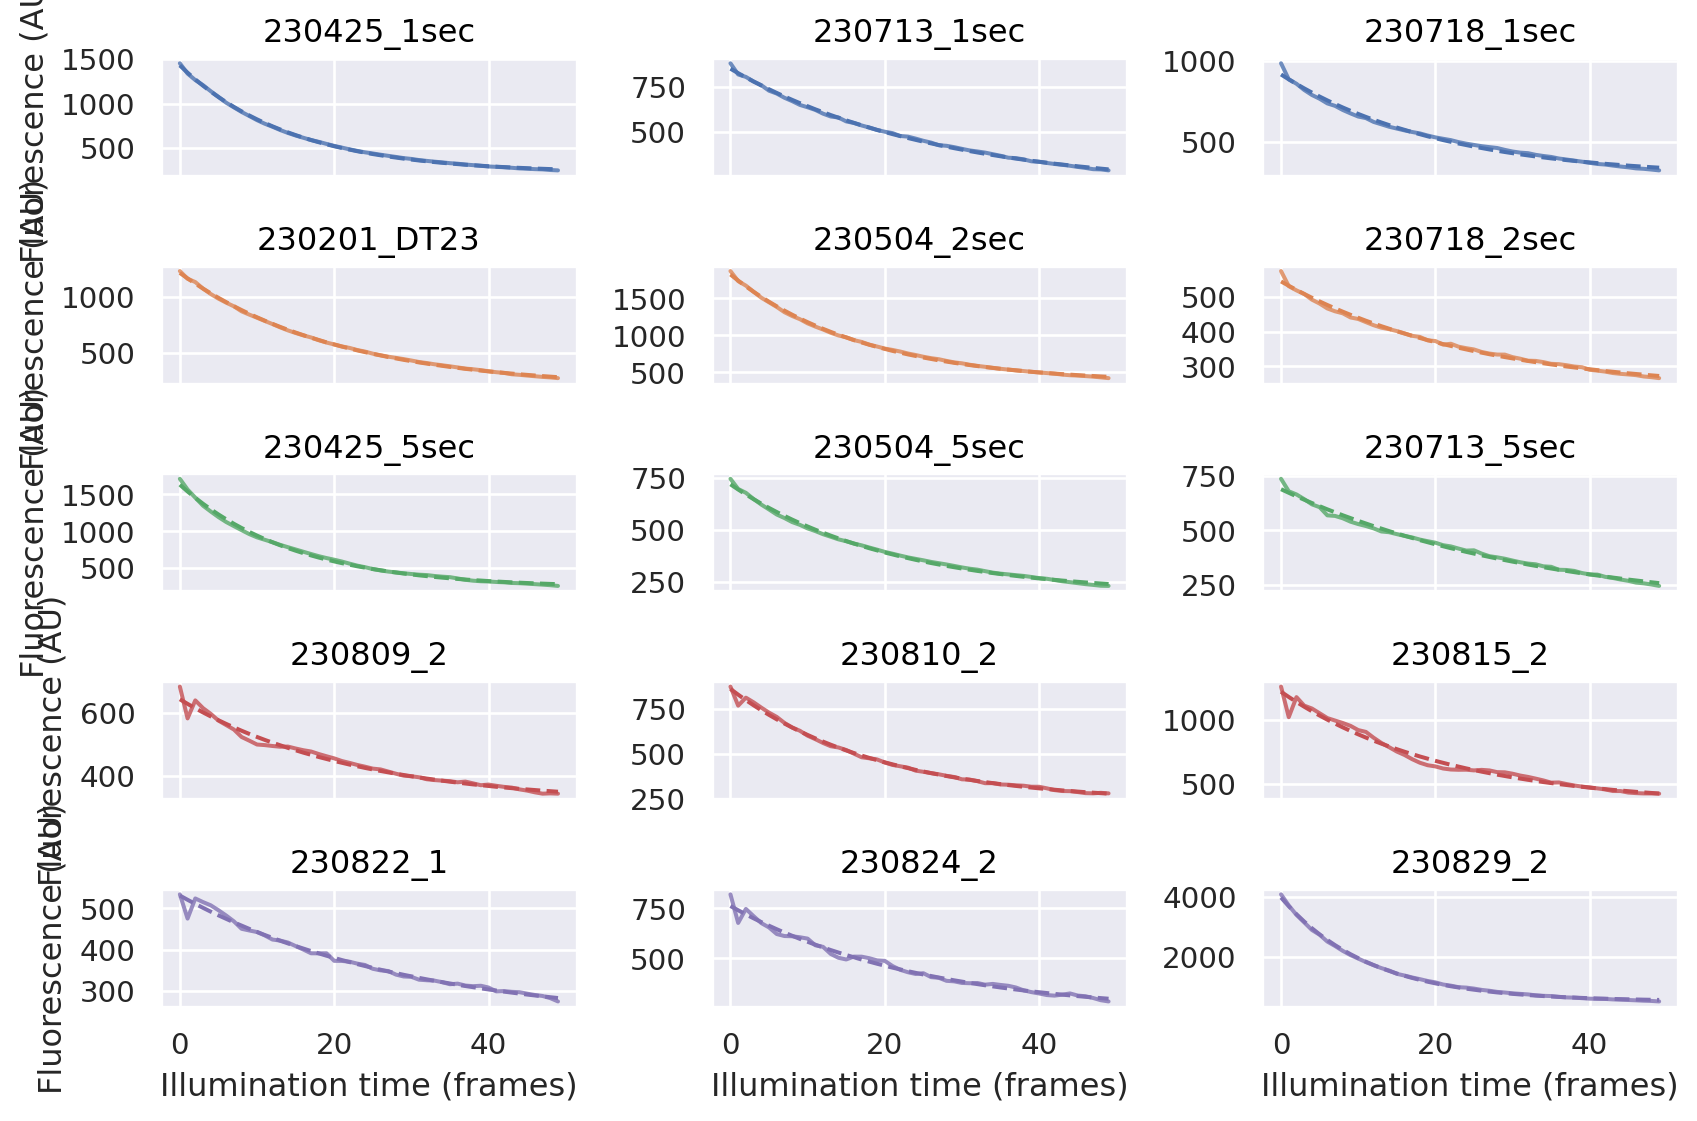

In [3]:
(
    so.Plot(bleaching_fit.data, x='Frame', color='Group')
    .layout(size=(9, 6))
    .facet(col='Dataset', wrap=3)
    .add(so.Line(alpha=.8), so.Agg(), y='SNR', legend=False)
    .add(so.Line(linestyle='--'), y='Fit', legend=False)
    .scale(color='deep')
    .share(y=False)
    .limit(x=(None, None), y=(None, None))
    .label(x="Illumination time (frames)", y="Fluorescence (AU)", color='')
)

### Show fitted parameters

There are three fitted parameters in the model:
- Amplitude (adjusts the height of the first point)
- Rate (the bleaching rate)
- Offset (a constant offset that accounts for any cellular autofluorescence)

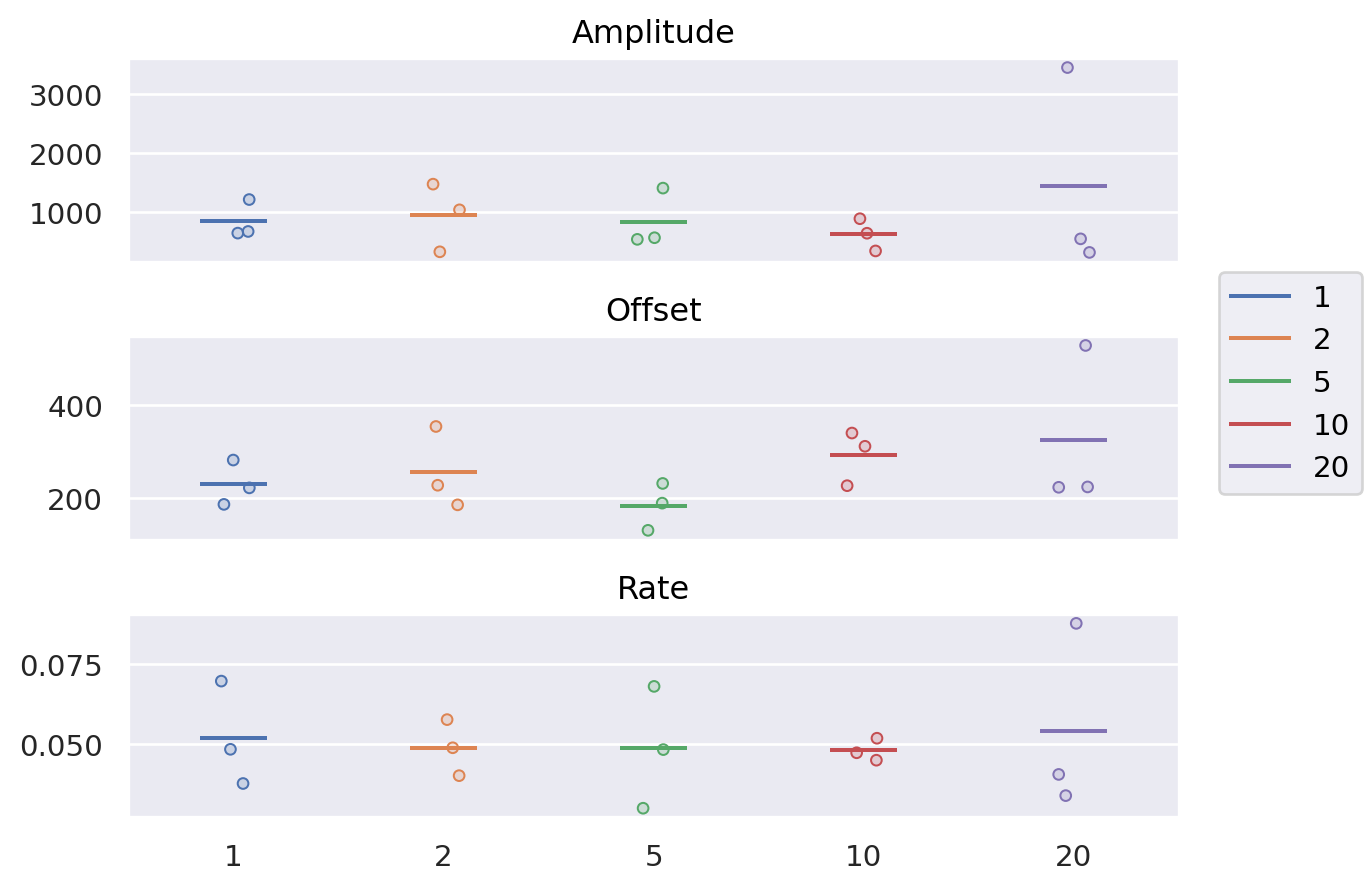

In [4]:
bleaching_parameters = bleaching_fit.get_fit_parameters(param_names=['Amplitude', 'Rate', 'Offset'])

(
    so.Plot(bleaching_parameters, x='Group', y='Fitted_param', color='Group')
    .facet(row='Param_name')
    .add(so.Dots(), so.Jitter(), legend=False)
    .add(so.Dash(width=.3), so.Agg('mean'))
    .scale(color='deep')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="", color='')
)

### Adjust bleahcing rates to frame time

The rate fitted above is a rate "per frame". Divide it by the frame interval (sec) to obtain the bleaching rate per second (adjusted rate).

In [5]:
bleaching_rates = (bleaching_parameters
                   .query('Param_name == "Rate"')
                   .assign(Frame_interval=data.groups,
                           Adjusted_rate=lambda df: df.Fitted_param.div(df.Frame_interval))
                   )

display(bleaching_rates)

,Group,Fitted_param,Param_name,Dataset,Frame_interval,Adjusted_rate
1,1,0.069690,Rate,230425_1sec,1,0.069690
4,1,0.037802,Rate,230713_1sec,1,0.037802
7,1,0.048447,Rate,230718_1sec,1,0.048447
10,2,0.048929,Rate,230201_DT23,2,0.024465
13,2,0.057697,Rate,230504_2sec,2,0.028849
16,2,0.040244,Rate,230718_2sec,2,0.020122
19,5,0.068043,Rate,230425_5sec,5,0.013609
22,5,0.048357,Rate,230504_5sec,5,0.009671
25,5,0.030104,Rate,230713_5sec,5,0.006021
28,10,0.045059,Rate,230809_2,10,0.004506


## Fit the spot lifetime histogram

In [6]:
from pyberries.data import Fit, get_histogram

hist = get_histogram(data.Spot_detection, col='TrackLength', binsize=1, groupby=['Dataset','Group'], density=True, binlabels='left')
lifetime_fit = Fit(hist, x='TrackLength', y='proportion', model_type='biexp_decay',
                   groupby=['Dataset','Group'], p0=[hist.TrackLength.iloc[0], 1, hist.TrackLength.iloc[0]/10, .1])

### Show the fits

Note: set the y limit to `(None, 0.15)` to check if the histogram tail is well fitted.

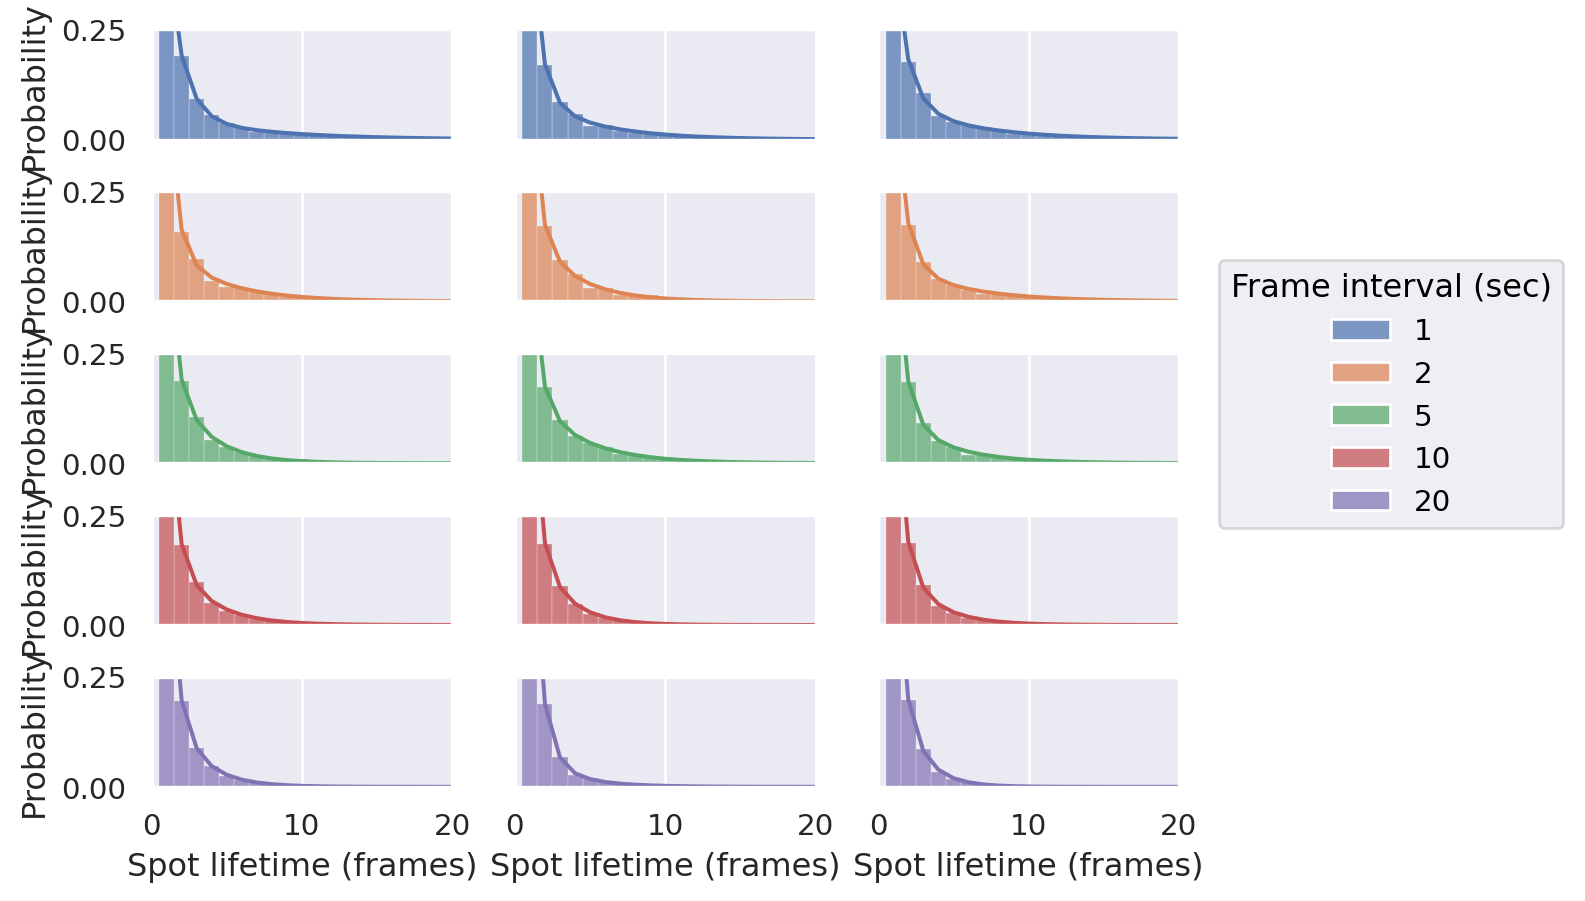

In [7]:
(
    so.Plot(lifetime_fit.data, x='TrackLength', color='Group')
    .facet(col='Dataset', wrap=3)
    .add(so.Bars(), y='proportion')
    .add(so.Line(), y='Fit', legend=False)
    .scale(color='deep')
    .limit(x=(0, 20), y=(None, 0.25))
    .label(x="Spot lifetime (frames)", y="Probability", color='Frame interval (sec)', title='')
)

### Display the rate summary

Retrieve the RecB dissociation rates, with bleaching subtracted for each dataset respectively.

In [9]:
rates = (lifetime_fit.get_rates(
                               dt=list(bleaching_rates.Frame_interval),
                               offset=list(bleaching_rates.Adjusted_rate)
                               )
        .assign(Frame_interval=lambda df: df.Group + 'sec')
        )

print('Average rates:')
display(rates.groupby(['Group', 'Rate_type'], sort=False, observed=True)[['Rate', 'Population']].agg(['mean', 'std']))

Average rates:


Rate           Population          
                     mean       std       mean       std
Group Rate_type                                         
1     Fast       1.120237  0.219710   0.926631  0.017275
      Slow       0.149800  0.052182   0.073369  0.017275
2     Fast       0.753379  0.107770   0.917301  0.020522
      Slow       0.117775  0.028437   0.082699  0.020522
5     Fast       0.312850  0.032872   0.887533  0.031325
      Slow       0.058309  0.010902   0.112467  0.031325
10    Fast       0.164654  0.012402   0.880208  0.008185
      Slow       0.039576  0.004039   0.119792  0.008185
20    Fast       0.077231  0.006323   0.875214  0.074115
      Slow       0.022887  0.005087   0.124786  0.074115

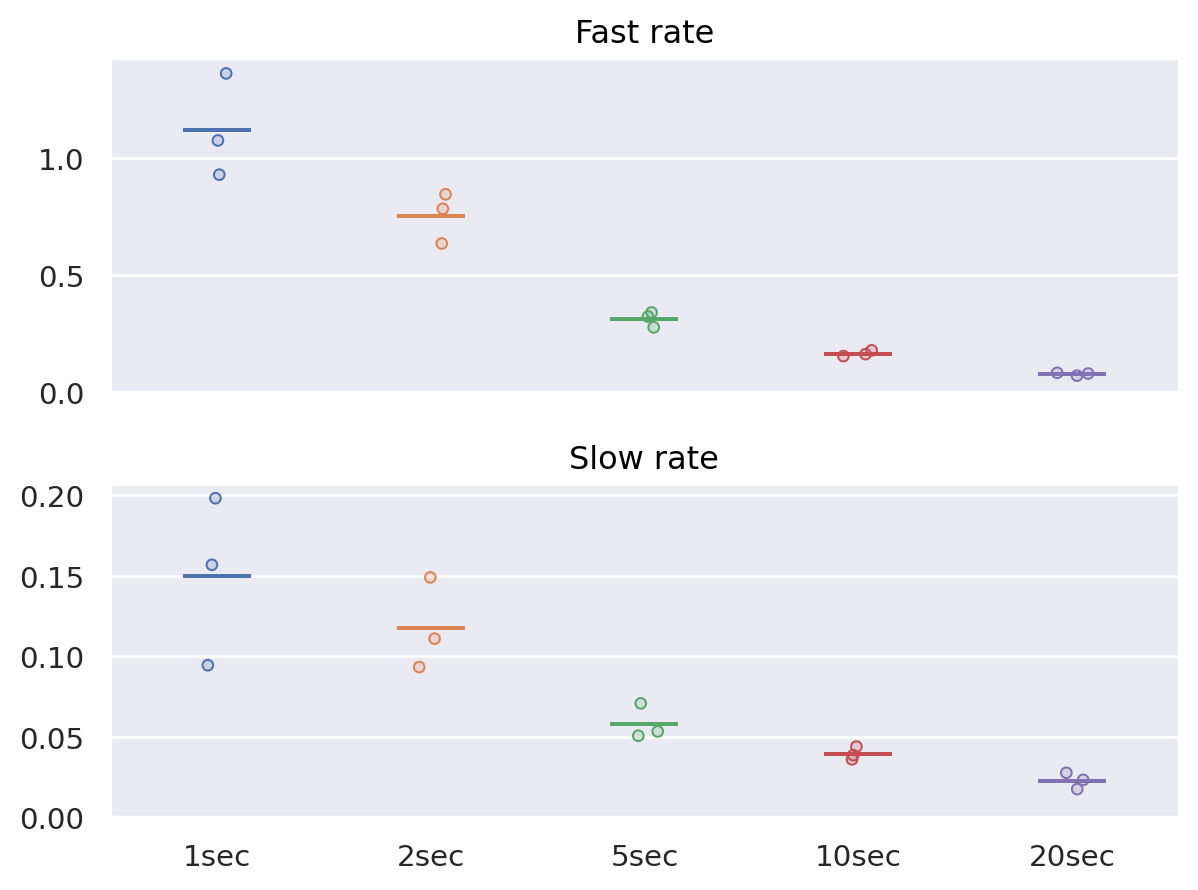

In [10]:
(
    so.Plot(rates, x='Frame_interval', y='Rate', color='Group')
    .facet(row='Rate_type')
    .add(so.Dots(), so.Jitter(), legend=False)
    .add(so.Dash(width=.3), so.Agg('mean'), legend=False)
    .scale(color='deep')
    .share(y=False)
    .limit(y=(0, None))
    .label(x="", y="", color='', title="{} rate".format)
)

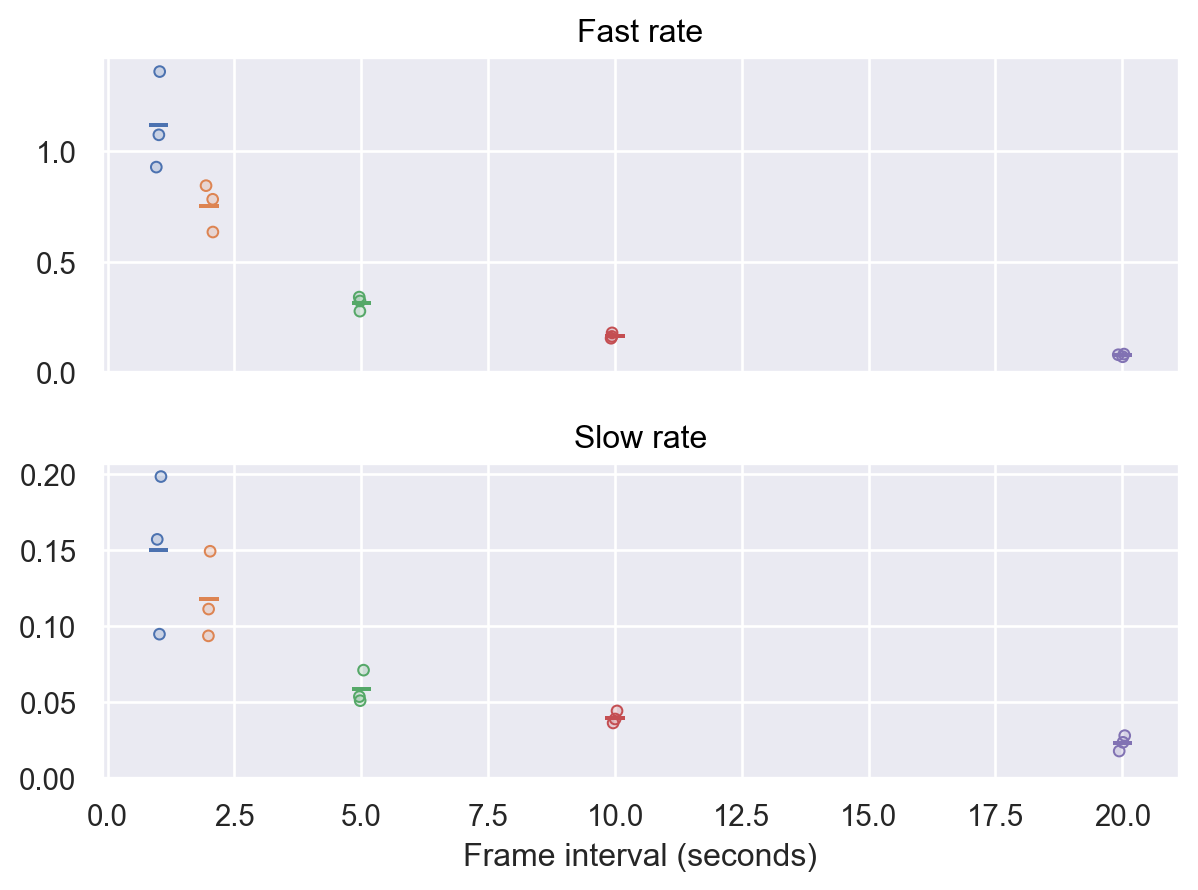

In [11]:
(
    so.Plot(rates.astype({'Group':'int'}), x='Group', y='Rate', color='Group')
    .facet(row='Rate_type')
    .add(so.Dots(), so.Jitter(), legend=False)
    .add(so.Dash(width=.3), so.Agg('mean'), legend=False)
    .scale(color='deep')
    .share(y=False)
    .limit(y=(0, None))
    .label(x="Frame interval (seconds)", y="", color='', title="{} rate".format)
)

### Fitted populations

Inspect the proportion of slow dissociation rates for each frame interval.

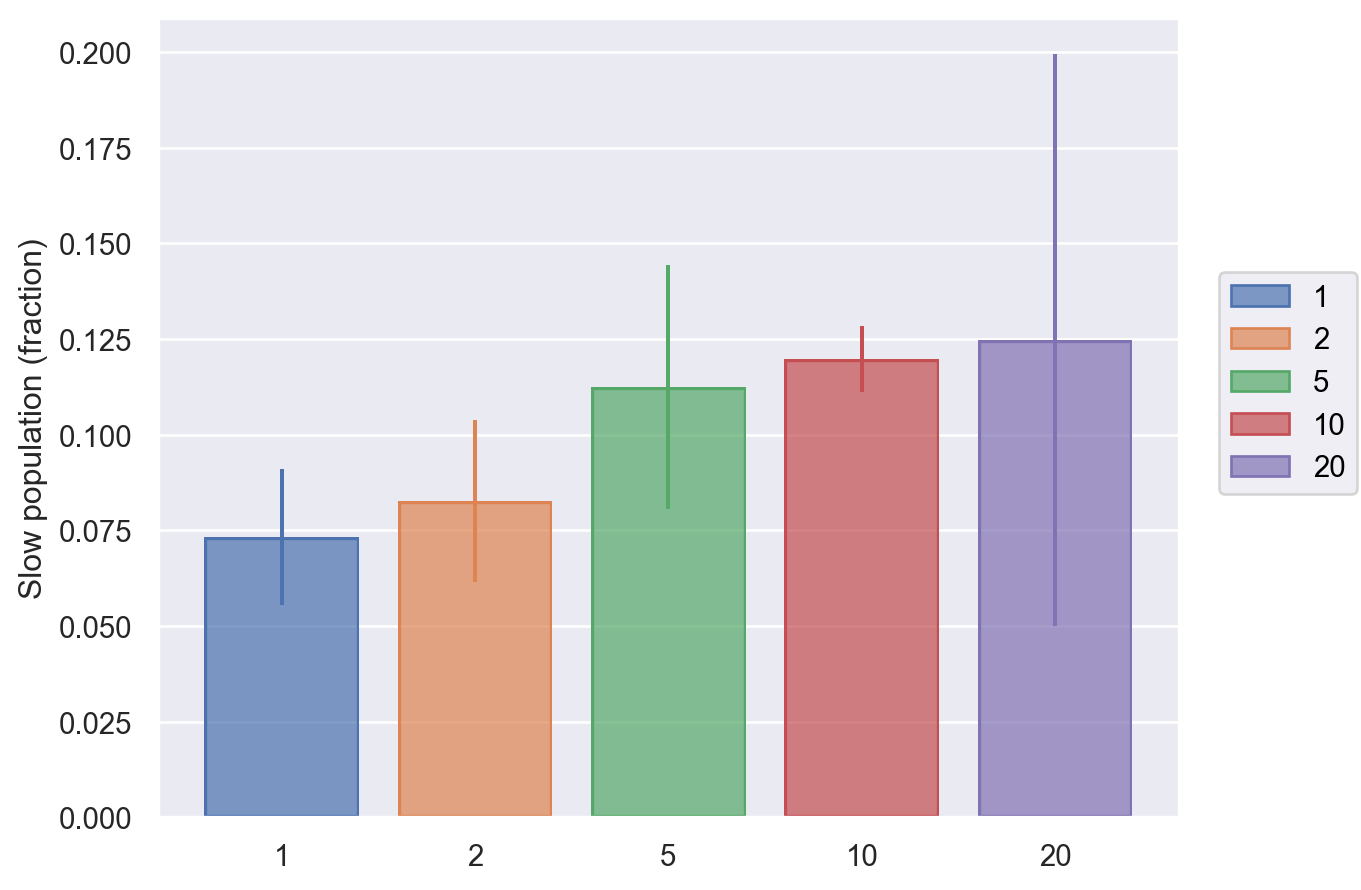

In [12]:
(
    so.Plot(data=rates.query('Rate_type == "Slow"'), x='Group', y='Population', color='Group')
    .add(so.Bar(), so.Agg())
    .add(so.Range(), so.Est(errorbar="sd"), legend=False)
    .limit(x=(None, None), y=(None, None))
    .label(x="", y="Slow population (fraction)", title='', color='')
)